In [172]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing

In [173]:
# Loading the MNIST datasets - 60000 images for training and 10000 images for testing
(imageTrainRaw, labelTrainRaw), (imageTestRaw, labelTestRaw) = tf.keras.datasets.mnist.load_data()

# Splitting the training set into 2: 55000 images for training and 5000 images for validation
imageTestRaw = imageTestRaw[:]
labelTestRaw = labelTestRaw[:]
sizeTest = 10000

imageValidRaw = imageTrainRaw[55000:]
labelValidRaw = labelTrainRaw[55000:]
sizeValid = 5000

imageTrainRaw = imageTrainRaw[:55000]
labelTrainRaw = labelTrainRaw[:55000]
sizeTrain = 55000

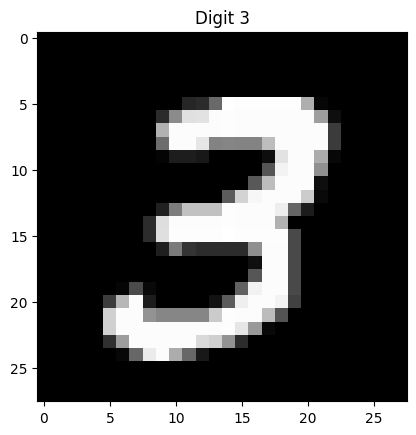

In [174]:
# Visualizing data
# Printing an array
def printArr(idx):
    to_write = ""
    for i in range(28):
        for j in range(28):
            if(len(str(imageTrainRaw[idx][i][j])) == 1):
                to_write += str(imageTrainRaw[idx][i][j]) + "    "
            elif(len(str(imageTrainRaw[idx][i][j])) == 2):
                to_write += str(imageTrainRaw[idx][i][j]) + "   "
            else:
                to_write += str(imageTrainRaw[idx][i][j]) + "  "
        to_write += "\n"
    to_write += f"\nDigit: {labelTrainRaw[idx]}"
    with open("./test/imageArr.txt", "w") as file:
        file.write(to_write)
        
# Plotting an image
def plotImage(idx):
    pyplot.title(f"Digit {labelTrainRaw[idx]}")
    pyplot.imshow(imageTrainRaw[idx], cmap='gray')
    pyplot.savefig("./test/digitGrey.jpg")

idx = 7
printArr(idx)
plotImage(idx)

In [175]:
# Preprocessing data (normalizing image arrays and 1-hot encoding label arrays)
imageTest = np.reshape(imageTestRaw, (10000, 784))
imageTest = preprocessing.normalize(imageTest, norm = "max")
labelTest = tf.keras.utils.to_categorical(labelTestRaw, num_classes=10)

imageValid = np.reshape(imageValidRaw, (5000, 784))
imageValid = preprocessing.normalize(imageValid, norm = "max")
labelValid = tf.keras.utils.to_categorical(labelValidRaw, num_classes=10)

imageTrain = np.reshape(imageTrainRaw, (55000, 784))
imageTrain = preprocessing.normalize(imageTrain, norm="max")
labelTrain = tf.keras.utils.to_categorical(labelTrainRaw, num_classes=10)

In [176]:
# Setting up the neural network layer dimension and hypermeters 
iter = 10000      # Number of iterations
eta = 0.05        # Initial learning rate
dInput = 784      # Input layer (28x28 pixels)
dHidden = 400     # Hidden layer (16x16 pixel)
dOutput = 10      # Output layer (0-9 digits)

In [177]:
# ReLU activation for hidden layer
def relu(x):
    return np.maximum(0, x)

# Softmax activation for output layer
def softmax(x):
    c = np.max(x, axis = 0, keepdims=True)
    x -= c
    e = np.exp(x)
    return e / np.sum(e, axis = 0, keepdims=True)

# Calculating loss value using cross entropy
def flossCE(yCal, yLabel, batchSize):
    result = -np.sum(np.log(yCal) * yLabel) / batchSize
    return result

def crossEntropy(batchSize, filename):
    # Initializing weights, biases and eta
    w1 = 0.01 * np.random.rand(dInput, dHidden)
    b1 = 0.01 * np.random.rand(dHidden, batchSize)
    w2 = 0.01 * np.random.rand(dHidden, dOutput)
    b2 = 0.01 * np.random.rand(dOutput, batchSize)

    lossList = []
    lossPrev = 100000
    to_write = ""
    for n in range(iter + 1):
        idxList = np.random.randint(sizeTrain, size=batchSize)
        # Feedforward
        x = imageTrain[idxList].T
        z1 = np.dot(w1.T, x) + b1
        a1 = relu(z1)
        z2 = np.dot(w2.T, a1) + b2
        a2 = softmax(z2)
        
        yCal = a2 
        yLabel = labelTrain[idxList].T
        loss = flossCE(yCal, yLabel, batchSize) 
        
        if(loss < lossPrev):
            lossPrev = loss
            w1Res = w1
            b1Res = b1
            w2Res = w2
            b2Res = b2
            # print(f"[Iter {n}] Loss: {loss}")
            to_write += f"[Iter {n}] Loss: {loss}\n"
            
        # Backpropagation
        e2 = (yCal - yLabel) / batchSize # gradient of softmax using cross entropy
        dw2 = np.dot(a1, e2.T)
        db2 = np.sum(e2, axis = 1, keepdims=True)
        e1 = np.dot(w2, e2)
        e1[z1 <= 0] = 0 # gradient of ReLU
        dw1 = np.dot(x, e1.T)
        db1 = np.sum(e1, axis = 1, keepdims=True)

        # Updating weights and biases
        w1 += -eta * dw1
        b1 += -eta * db1
        w2 += -eta * dw2
        b2 += -eta * db2
        
        if(n % 50 == 0):
            lossList.append(loss)
    
    with open(f"./test/{filename}.txt", "w") as file:
        file.write(to_write)
        
    return (w1Res, b1Res, w2Res, b2Res, lossList)

In [180]:
def checkValid(w1Res, b1Res, w2Res, b2Res, batchSize):
    if(batchSize > sizeValid):
        batchSize = sizeValid
    count = 0
    batch = 0
    while batch < sizeValid:
        idxList = np.arange(batch, batch + batchSize, 1)
        x = imageValid[idxList].T
        z1 = np.dot(w1Res.T, x) + b1Res
        a1 = relu(z1)
        z2 = np.dot(w2Res.T, a1) + b2Res
        a2 = softmax(z2)
        yLabel = labelValid[idxList]
        prediction = np.argmax(a2.T, axis=1)
        answer = np.argmax(yLabel, axis=1)
        for n in range(batchSize):
            if(prediction[n] == answer[n]):
                count += 1
        batch += batchSize
    return count / sizeValid
    
def checkTest(w1Res, b1Res, w2Res, b2Res, batchSize):
    if(batchSize > sizeTest):
        batchSize = sizeTest
    count = 0
    batch = 0
    while batch < sizeTest:
        idxList = np.arange(batch, batch + batchSize, 1)
        x = imageTest[idxList].T
        z1 = np.dot(w1Res.T, x) + b1Res
        a1 = relu(z1)
        z2 = np.dot(w2Res.T, a1) + b2Res
        a2 = softmax(z2)
        yLabel = labelTest[idxList]
        prediction = np.argmax(a2.T, axis=1)
        answer = np.argmax(yLabel, axis=1)
        for n in range(batchSize):
            if(prediction[n] == answer[n]):
                count += 1
        batch += batchSize
    return count / sizeTest

Testing on validation set: 97.12%
Testing on testing set: 96.6%
Testing on validation set: 97.2%
Testing on testing set: 96.58%


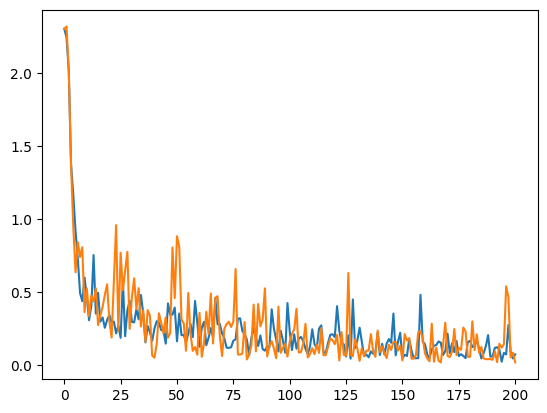

In [179]:
# Mini BGD with batch size = 50
(mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, miniLoss1) = crossEntropy(batchSize=50, filename="miniLoss1")
resultValid = checkValid(mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, batchSize=50)
print(f"Testing on validation set: {100 * resultValid}%")
resultTest = checkTest(mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, batchSize=50)
print(f"Testing on testing set: {100 * resultTest}%")

(mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, miniLoss2) = crossEntropy(batchSize=25, filename="miniLoss2")
resultValid = checkValid(mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, batchSize=25)
print(f"Testing on validation set: {100 * resultValid}%")
resultTest = checkTest(mini_w1Res, mini_b1Res, mini_w2Res, mini_b2Res, batchSize=25)
print(f"Testing on testing set: {100 * resultTest}%")

# (full_w1Res, full_b1Res, full_w2Res, full_b2Res, fullLoss) = crossEntropy(batchSize=55000, filename="fullLoss")
# resultValid(full_w1Res, full_b1Res, full_w2Res, full_b2Res, batchSize = 55000)
# resultTest(full_w1Res, full_b1Res, full_w2Res, full_b2Res, batchSize = 55000)
pyplot.plot(miniLoss1)
pyplot.plot(miniLoss2)
pyplot.show() 